<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/5_7_extract_features_from_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Many thanks to [Chris McCormick](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

In [30]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -U -q PyDrive

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


stimuli_table_id = 'https://drive.google.com/open?id=1cVQXOhkaUYRJWgy65Zb1WQh0YJLEOAmH'.split('id=')[-1]

stimuli_ = drive.CreateFile({'id':stimuli_table_id})

stimuli_.GetContentFile('{}'.format('definitions.txt'))

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 636 kB 19.1 MB/s 
     |████████████████████████████████| 895 kB 61.1 MB/s 
     |████████████████████████████████| 3.3 MB 50.6 MB/s 


# load the sentences

In [31]:
import torch
import pandas as pd
import numpy as np
# load the stimuli table
stimuli_table = pd.read_csv('definitions.txt', sep='\t').sort_values(['Likableness','Condition']).reset_index(drop = True)
sentences = stimuli_table['Definition'].to_list()
sentences

['No siente compasión ante el sufrimiento ajeno o se deleita con él',
 'Ni se emociona ni percibe los sentimientos de los demás',
 'Cuando habla hace que los demás se sientan despreciados',
 'No perdona nada a nadie ni muestra compasión alguna',
 'Se desespera porque sólo puede ver el aspecto más negativo de las cosas',
 'Se comporta como si la vida le maltratara todo el rato',
 'Es muy inestable y reacciona ante las cosas de forma emocional y exagerada',
 'Pierde la calma con facilidad y reacciona de forma agresiva ante los demás',
 'Se siente triste o enfadado/a cuando no tiene lo mismo que otras personas',
 'Se hace pasar por alguien que no es para engañar a los demás',
 'Siempre intenta acumular más y más cosas, y nunca las comparte con nadie más',
 'No tiene buenos modales y habla sin respetar a los demás',
 'No se interesa por el interés de los demás, sólo por su propia conveniencia',
 'Tiene una actitud provocativa y abusiva hacia otros',
 'Fastidia a los demás con su falta de d

In [ ]:
token_max_length = 21

# Load the BERT model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("Recognai/bert-base-spanish-wwm-cased-xnli")
tokenizer.model_max_length = token_max_length
model = AutoModelForSequenceClassification.from_pretrained("Recognai/bert-base-spanish-wwm-cased-xnli",output_hidden_states = True)

In [ ]:
encoded_dict = tokenizer(
                        sentences,                      # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        padding = 'max_length',            # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
outputs = model(**encoded_dict)

# dimension of the output hidden states: n_layers = 13, n_words, n_tokens, n_features

## We want the 9th hidden state

In [ ]:
print(len(outputs['hidden_states']))
outputs['hidden_states'][9].shape

13


torch.Size([36, 21, 768])

# Flatten the last 2 dimensions of the representations of the hidden states (n_words, n_tokens, n_features)

In [ ]:
idx_layer = 9
a = outputs['hidden_states'][idx_layer].view(36,-1).detach().cpu().numpy()
a.shape

(36, 16128)

In [ ]:
df_bert = pd.DataFrame(a.T,columns = stimuli_table['Concept'])
df_bert.to_csv('bert_features.csv',index = False)

# compute and plot the RDM

## The 3 RDM plots are the same except the labels of the axes are different.

In [36]:
from scipy.spatial import distance as SD
from matplotlib import pyplot as plt

In [ ]:
#a = a.reshape(36,32,768)[:,0,:]
RDM = SD.squareform(SD.pdist(a - a.mean(1).reshape(-1,1),'cosine'))
np.fill_diagonal(RDM,np.nan)

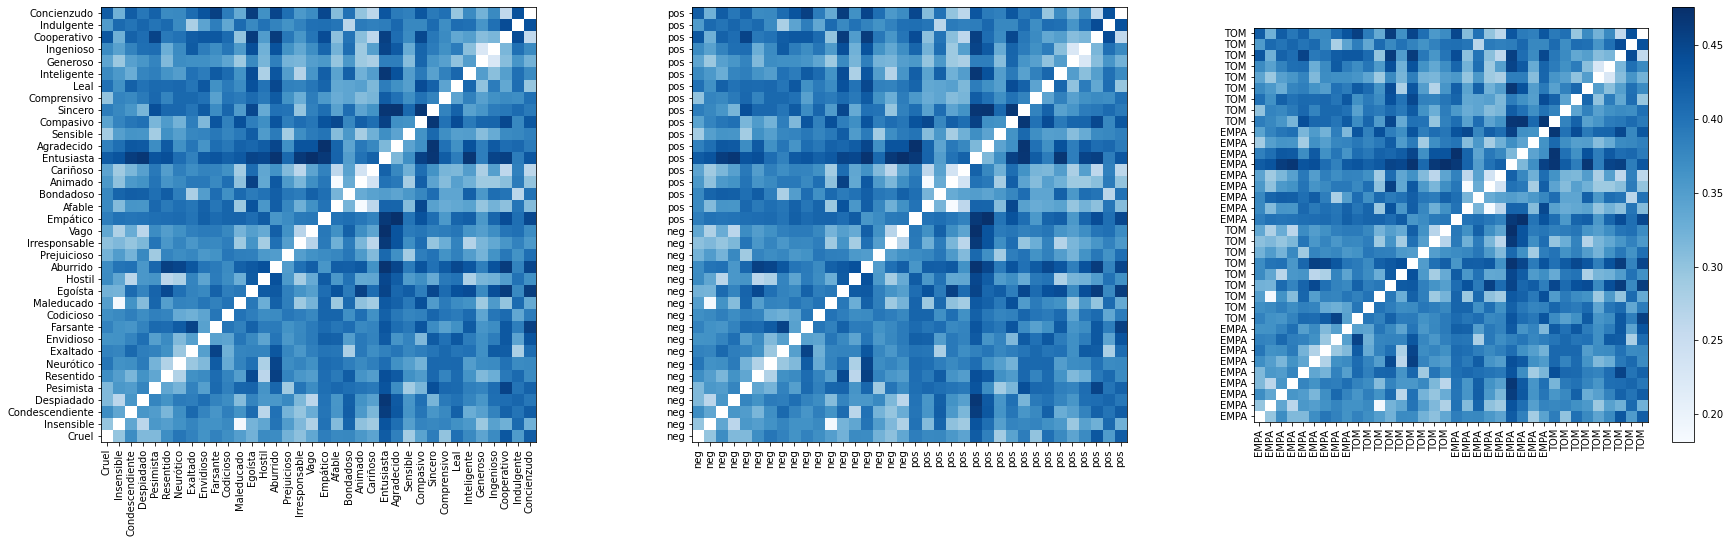

In [ ]:
fig,axes = plt.subplots(figsize = (10 * 3,8),
                        ncols = 3)
vmax = None
ax = axes.flatten()[0]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Concept'],)
_ = ax.set_xticklabels(stimuli_table['Concept'],rotation = 90)

ax = axes.flatten()[1]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Likableness'],)
_ = ax.set_xticklabels(stimuli_table['Likableness'],rotation = 90)

ax = axes.flatten()[2]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Condition'],)
_ = ax.set_xticklabels(stimuli_table['Condition'],rotation = 90)

# Load the GPT-2 model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
del tokenizer
tokenizer = AutoTokenizer.from_pretrained("DeepESP/gpt2-spanish",)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens = True
tokenizer.model_max_length = token_max_length
del model
model = AutoModelForSequenceClassification.from_pretrained("DeepESP/gpt2-spanish",output_hidden_states = True)

Some weights of the model checkpoint at DeepESP/gpt2-spanish were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at DeepESP/gpt2-spanish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = [tokenizer.encode(item,padding = 'max_length',return_tensors='pt') for item in sentences]
idx_layer = 9
outputs = torch.cat([model(item)[2][idx_layer] for item in inputs])
a = outputs.view(36,-1).detach().cpu().numpy()

In [ ]:
df_gpt = pd.DataFrame(a.T,columns = stimuli_table['Concept'])
df_gpt.to_csv('GPT2_features.csv',index = False)

In [ ]:
#a = a.reshape(36,32,768)[:,0,:]
RDM = SD.squareform(SD.pdist(a - a.mean(1).reshape(-1,1),'cosine'))
np.fill_diagonal(RDM,np.nan)

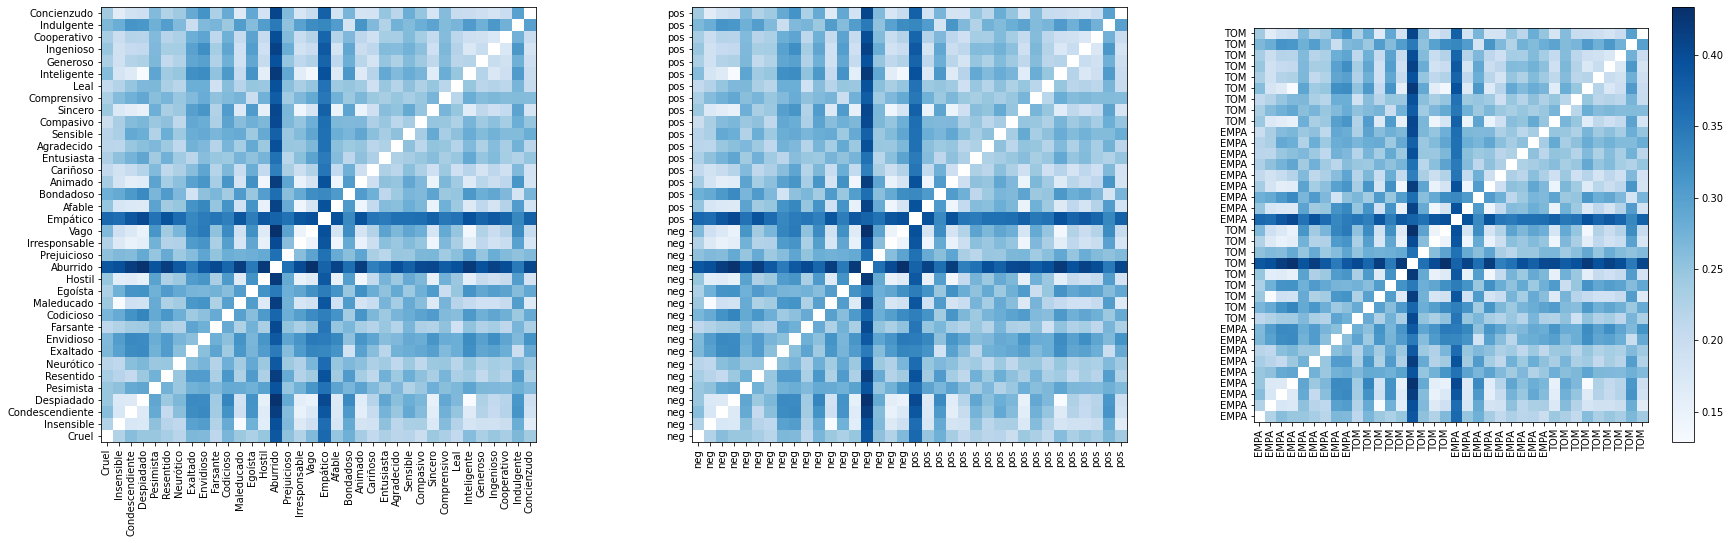

In [ ]:
fig,axes = plt.subplots(figsize = (10 * 3,8),
                        ncols = 3)
vmax = None
ax = axes.flatten()[0]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Concept'],)
_ = ax.set_xticklabels(stimuli_table['Concept'],rotation = 90)

ax = axes.flatten()[1]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Likableness'],)
_ = ax.set_xticklabels(stimuli_table['Likableness'],rotation = 90)

ax = axes.flatten()[2]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Condition'],)
_ = ax.set_xticklabels(stimuli_table['Condition'],rotation = 90)

# Use GPT2 as a word2vec model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
del tokenizer
tokenizer = AutoTokenizer.from_pretrained("DeepESP/gpt2-spanish",)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens = True
tokenizer.model_max_length = token_max_length
del model
model = AutoModelForSequenceClassification.from_pretrained("DeepESP/gpt2-spanish",output_hidden_states = True)

Some weights of the model checkpoint at DeepESP/gpt2-spanish were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at DeepESP/gpt2-spanish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = [tokenizer.encode(item.lower(),padding = 'max_length',return_tensors='pt') for item in stimuli_table['Concept'].to_list()]
idx_layer = 9
outputs = torch.cat([model(item)[2][idx_layer] for item in inputs])
a = outputs.view(36,-1).detach().cpu().numpy()

In [ ]:
df_gpt = pd.DataFrame(a.T,columns = stimuli_table['Concept'])
df_gpt.to_csv('GPT2-concept_features.csv',index = False)

In [ ]:
#a = a.reshape(36,32,768)[:,0,:]
RDM = SD.squareform(SD.pdist(a - a.mean(1).reshape(-1,1),'cosine'))
np.fill_diagonal(RDM,np.nan)

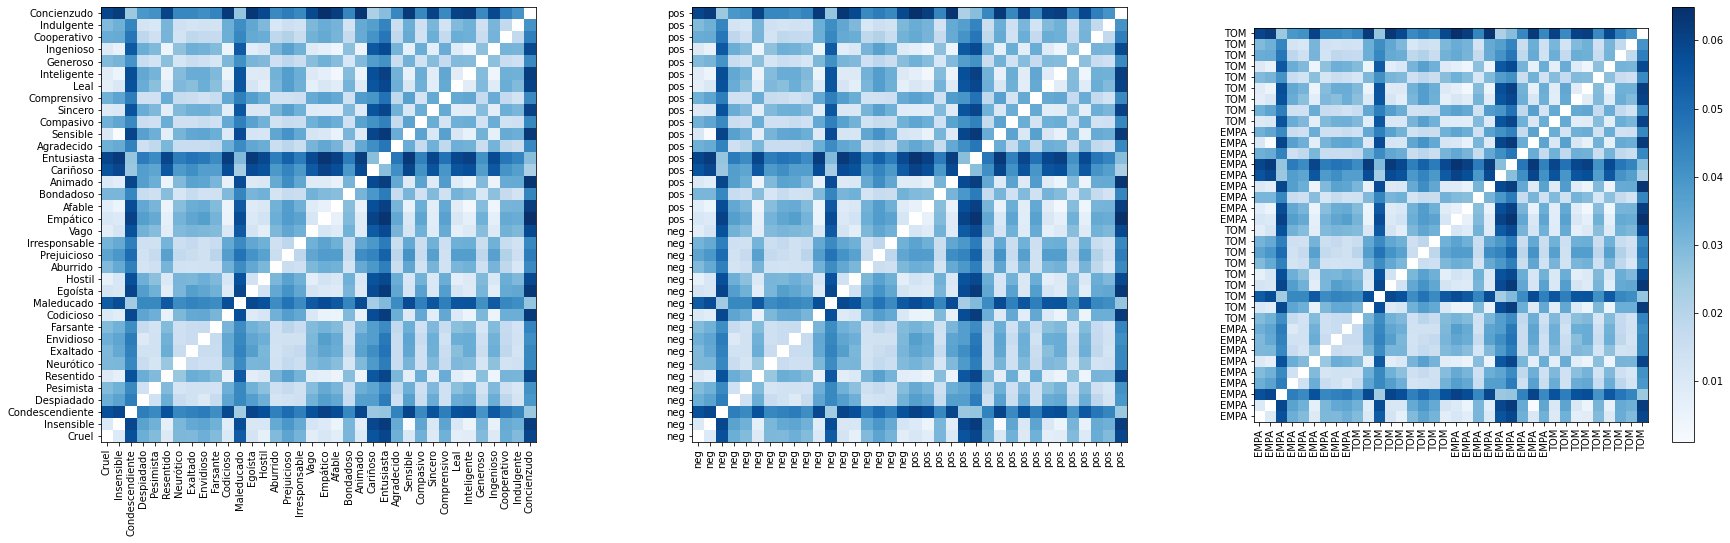

In [ ]:
fig,axes = plt.subplots(figsize = (10 * 3,8),
                        ncols = 3)
vmax = None
ax = axes.flatten()[0]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Concept'],)
_ = ax.set_xticklabels(stimuli_table['Concept'],rotation = 90)

ax = axes.flatten()[1]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Likableness'],)
_ = ax.set_xticklabels(stimuli_table['Likableness'],rotation = 90)

ax = axes.flatten()[2]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Condition'],)
_ = ax.set_xticklabels(stimuli_table['Condition'],rotation = 90)

# Load [fast text](https://fasttext.cc/docs/en/crawl-vectors.html#models) because it is easy, but the pretrained model is huge, so I will remove everything after loading the model so I don't max out RAM

In [11]:
try:
    import fasttext
except:
    !pip install fasttext
    import fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
!gunzip cc.es.300.bin.gz
!rm cc.es.300.bin.gz

model = fasttext.load_model(ft)

!rm cc.es.300.bin

--2021-09-17 10:06:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500107671 (4.2G) [application/octet-stream]
Saving to: ‘cc.es.300.bin.gz’

cc.es.300.bin.gz    100%[===================>]   4.19G  35.8MB/s    in 2m 15s  

2021-09-17 10:09:14 (31.9 MB/s) - ‘cc.es.300.bin.gz’ saved [4500107671/4500107671]



In [32]:
vecs = np.array([model[item.lower()] for item in stimuli_table['Concept']])

In [34]:
df_ft = pd.DataFrame(vecs.T,columns = stimuli_table['Concept'])
df_ft.to_csv('fast-text_features.csv',index = False)

In [37]:
RDM = SD.squareform(SD.pdist(vecs - vecs.mean(1).reshape(-1,1),'cosine'))
np.fill_diagonal(RDM,np.nan)

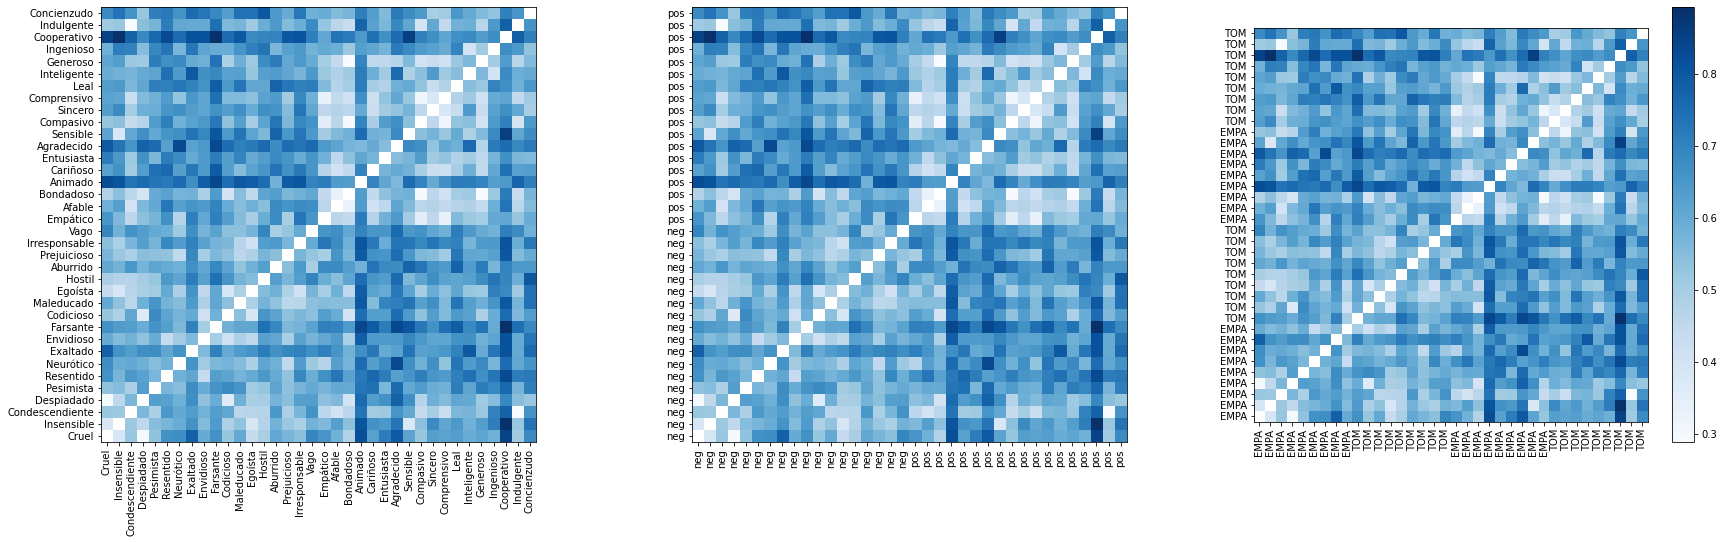

In [38]:
fig,axes = plt.subplots(figsize = (10 * 3,8),
                        ncols = 3)
vmax = None
ax = axes.flatten()[0]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Concept'],)
_ = ax.set_xticklabels(stimuli_table['Concept'],rotation = 90)

ax = axes.flatten()[1]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Likableness'],)
_ = ax.set_xticklabels(stimuli_table['Likableness'],rotation = 90)

ax = axes.flatten()[2]
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = vmax)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Condition'],)
_ = ax.set_xticklabels(stimuli_table['Condition'],rotation = 90)